<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/09_GenerativeModels/Generating_molecules_with_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target: Generate new molecules from [SMILES](https://archive.epa.gov/med/med_archive_03/web/html/smiles.html) strings using a VAE (variational autoencoder) which is a generative model.

Dataset: [MUV dataset](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#muv-datasets) ( Maximum Unbiased Validation), the training set includes 74,469 molecules of varying sizes and structures.

## Setup

In [1]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

     |████████████████████████████████| 582 kB 28.4 MB/s 


'2.6.0.dev'

## Dataset
Loading MUV dataset

In [2]:
!pip install rdkit-pypi

     |████████████████████████████████| 18.6 MB 1.2 MB/s 


In [3]:
# ~ 8 minutes
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

Defining vocabulary (What is the list of characters that can appear in a string? - tokens)

In [4]:
tokens = set()

for s in train_smiles:
  tokens = tokens.union(set(s))

tokens = sorted(list(tokens))

max_length = max(len(s) for s in train_smiles)

## Model

We will use DeepChem's Aspuru Guzik AutoEncoder which uses a convolutional network for the encoder and a recurrent network for the decoder ([original paper](https://arxiv.org/abs/1610.02415) of the suggested architecture).

In [6]:
from deepchem.models.optimizers import Adam, ExponentialDecay
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder

In [7]:
batch_size = 128
optimizer = ExponentialDecay(initial_rate=0.001, decay_rate=0.95, decay_steps=len(train_smiles) // batch_size)
model = AspuruGuzikAutoEncoder(tokens, max_length, batch_size=batch_size, learning_rate=optimizer)

## Training

In [8]:
def generate_sequences(epochs):
  """Produces sequences of tokens"""
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

Note: The training will be completed in about 90 minutes. 

In [9]:
model.fit_sequences(generate_sequences(100))

## Testing 
Generating new molecules. We just need to pick random latent vectors and pass them through the decoder.

We will use RDKit to check valid SMILES strings and filter out the invalid ones.

In [10]:
import numpy as np
from rdkit import Chem

In [19]:
# 2000 latent vectors, each of lenght 196 (the size of the model's latent space)
predictions = model.predict_from_embeddings(np.random.normal(size=(2000, 196)))

print(len(predictions))

2000


In [21]:
molecules = []

for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)

print('Valid SMILES strings:') # maybe none is valid 
for m in molecules:
  print(m)

Valid SMILES strings:
Cc1nnc(CN2CCCCC2)ncc(-c2cccccscccc2C)n1
CS1ncc(C)nc(NCC)c(C)ccc(=O)n(C)c(C)c1O
Cc1cc2(CNnc(C)c(-Cc2cc2ncc3)c3)nccc12
Cc1ccc(C)n2CCc2ccccccc(C)c(CC)c(C)c1=O
Cc1cc(CO)n(CCCCCCC)n(C)nnc(C)c(C)n1


### Interesting to know

One factor we may want to examine is the size of the molecules. **Molecules with fewer than 10 atoms are unlikely to generate sufficient interaction energy to produce a measurable signal in a biological assay**. Conversely, **molecules with more than 50 atoms may not be capable of dissolving in water** and may create other problems in biological assays.

One of the more common methods for determining whether molecules are similar to known drugs, or “drug-like,” is known as the **quantitative estimate of druglikeness (QED)**. The QED metric, scores molecules by comparing a set of properties calculated for each molecule with distributions of the same properties in marketed drugs. 

This score ranges between 0 and 1, with values closer to 1 being considered more drug-like.



We will filter some molecules with QED and visualize some of them.

In [14]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.QED import qed

In [26]:
valid_molecules = []

for molecule_string_smile in molecules:
  molecule = Chem.MolFromSmiles(molecule_string_smile)
  print(molecule.GetNumAtoms())

  if molecule.GetNumAtoms() > 10 and molecule.GetNumAtoms() < 50:
    valid_molecules.append(molecule)

print('Valid molecules by lenght: {}/{}'.format(len(valid_molecules), len(molecules)))

28
23
22
25
23
Valid molecules by lenght: 5/5


In [28]:
qed_scores = [qed(x) for x in valid_molecules]
print(qed_scores)
final_molecules = [(a, b) for a, b in zip(valid_molecules, qed_scores) if b > 0.5]

print("Number of final molecules: {}".format(len(final_molecules)))

[0.6823285122559173, 0.6775447863306852, 0.7324523047891381, 0.6038916997346013, 0.7187373987736866]
Number of final molecules: 5


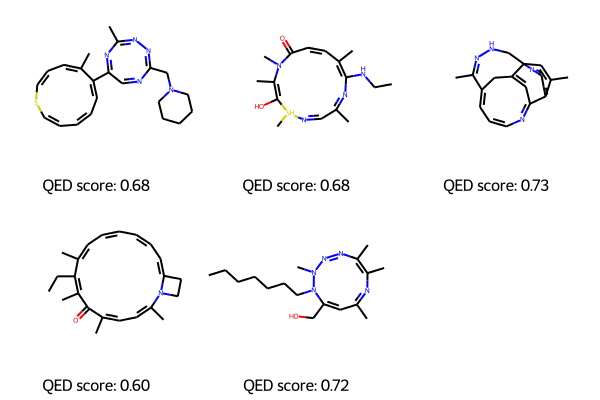

In [30]:
MolsToGridImage(
  mols=[x[0] for x in final_molecules], 
  molsPerRow=3, 
  legends=[f"QED score: {x[1]:.2f}" for x in final_molecules]
)